In [106]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import torch
import pandas as pd

In [107]:
file_path = './embeds/campplus_embeddings.csv'
df = pd.read_csv(file_path)

df.head()

,path,person_id,utterance_filename,embedding
0,./wav_files_voxceleb2/id08149/16.wav,id08149,16.wav,[-0.02879259 -0.04628501 0.79844713 -1.007444...
1,./wav_files_voxceleb2/id08149/17.wav,id08149,17.wav,[ 0.00339373 -0.56627667 1.8227887 -1.208145...
2,./wav_files_voxceleb2/id08149/15.wav,id08149,15.wav,[-0.13785703 -0.40674278 1.6309307 -1.681454...
3,./wav_files_voxceleb2/id08149/28.wav,id08149,28.wav,[ 0.24818708 -1.0722951 1.1296148 -0.814627...
4,./wav_files_voxceleb2/id08149/14.wav,id08149,14.wav,[ 1.44684181e-01 -5.41866601e-01 2.41425705e+...


In [108]:
df['embedding'] = df['embedding'].apply(lambda x: np.array(x.strip('[]').split(), dtype=float))
df.head()

,path,person_id,utterance_filename,embedding
0,./wav_files_voxceleb2/id08149/16.wav,id08149,16.wav,"[-0.02879259, -0.04628501, 0.79844713, -1.0074..."
1,./wav_files_voxceleb2/id08149/17.wav,id08149,17.wav,"[0.00339373, -0.56627667, 1.8227887, -1.208145..."
2,./wav_files_voxceleb2/id08149/15.wav,id08149,15.wav,"[-0.13785703, -0.40674278, 1.6309307, -1.68145..."
3,./wav_files_voxceleb2/id08149/28.wav,id08149,28.wav,"[0.24818708, -1.0722951, 1.1296148, -0.8146277..."
4,./wav_files_voxceleb2/id08149/14.wav,id08149,14.wav,"[0.144684181, -0.541866601, 2.41425705, 0.1363..."


In [109]:
# Check dimensions of all embeddings
df["embedding_length"] = df["embedding"].apply(len)
print(df["embedding_length"].value_counts())

embedding_length
192    2476
Name: count, dtype: int64


In [110]:
def cosine_similarity(e1, e2):
    cosine_score = torch.dot(e1, e2) / (torch.norm(e1) * torch.norm(e2))
    cosine_score = cosine_score.item()
    return (cosine_score + 1.0) / 2  # normalize: [-1, 1] => [0, 1]


def cosine_sim(tensor1: torch.Tensor, tensor2: torch.Tensor) -> torch.Tensor:

    tensor1_normalized = tensor1 / torch.norm(tensor1, dim=1, keepdim=True)
    tensor2_normalized = tensor2 / torch.norm(tensor2, dim=1, keepdim=True)

    cosine_similarity_matrix = torch.mm(tensor1_normalized, tensor2_normalized.T)

    normalized_similarity_matrix = (cosine_similarity_matrix + 1.0) / 2.0

    return normalized_similarity_matrix

In [111]:
embeddings = df['embedding'].values
embeddings_array = np.vstack(embeddings)
embeddings_tensor = torch.tensor(embeddings_array, dtype=torch.float32)

In [112]:
# embeddings is a array of array of floats i want to compute a matrix of cosine similarity each element of the matrix is the cosine similarity between the two embeddings
# using torch for this

similarity_matrix = cosine_sim(embeddings_tensor, embeddings_tensor)
# fill the diagonal with 

In [113]:
similarity_matrix.shape

torch.Size([2476, 2476])

In [114]:
labels = df["person_id"].values

In [115]:
labels_matrix = np.equal(labels[:, None], labels)
np.fill_diagonal(labels_matrix, False)
upper_triangle_indices = np.triu_indices_from(similarity_matrix, k=1)
class_labels = labels_matrix[upper_triangle_indices]
scores = similarity_matrix[upper_triangle_indices]



In [116]:
print( "class_labels", class_labels, "len", len(class_labels))
print("scores", scores, "len", len(scores))

class_labels [ True  True  True ...  True  True  True] len 3064050
scores tensor([0.9456, 0.9431, 0.8405,  ..., 0.7887, 0.8223, 0.8345]) len 3064050


In [117]:
genuine_scores = scores[class_labels]
impostor_scores = scores[~class_labels]

In [118]:
genuine_scores.shape, impostor_scores.shape

(torch.Size([60350]), torch.Size([3003700]))

In [119]:
# Combine scores and generate thresholds
thresholds = np.linspace(0, 1, 1000)  # Cosine similarity ranges from -1 to 1
FAR = []  # False Acceptance Rate
FRR = []  # False Rejection Rate

for threshold in thresholds:
    # FAR: Proportion of impostor scores >= threshold
    FAR.append(np.mean(np.array(impostor_scores) >= threshold))

    # FRR: Proportion of genuine scores < threshold
    FRR.append(np.mean(np.array(genuine_scores) < threshold))

# Find the threshold where FAR and FRR are equal (EER)
EER_index = np.argmin(np.abs(np.array(FAR) - np.array(FRR)))
EER = (FAR[EER_index] + FRR[EER_index]) / 2
EER_threshold = thresholds[EER_index]

print(f"EER: {EER:.4f} at threshold: {EER_threshold:.4f}")

EER: 0.1013 at threshold: 0.7317


In [120]:
import matplotlib.pyplot as plt

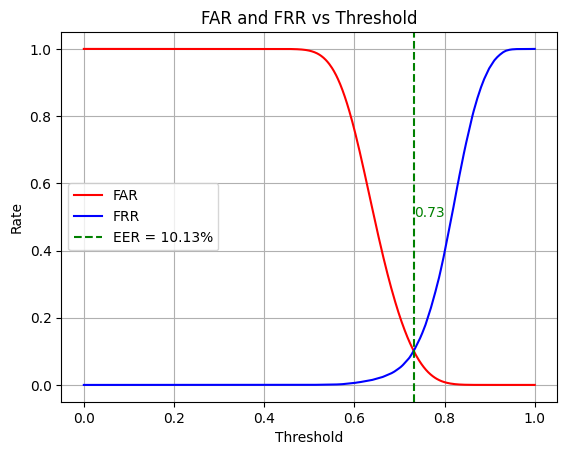

In [121]:
plt.plot(thresholds, FAR, label="FAR", color="red")
plt.plot(thresholds, FRR, label="FRR", color="blue")
plt.axvline(EER_threshold, color="green", linestyle="--", label=f"EER = {EER * 100:.2f}%")
plt.xlabel("Threshold")
plt.ylabel("Rate")
plt.title("FAR and FRR vs Threshold")
plt.legend()
plt.grid()

# Annotate the EER threshold
plt.text(EER_threshold, 0.5, f'{EER_threshold:.2f}', color="green")

plt.show()